In [ ]:
# Import Library yang diperlukan
import pandas as pd
import numpy as np
from urllib import request
import datetime
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Membaca file excel berisikan list koin yg ingin di proses
#list_koin = pd.read_excel('/content/List_Koin_Tokocrypto.xlsx')
list_koin = pd.DataFrame({'Koin' : ['ETHBIDR','BTCBIDR']})
list_koin

,Koin
0,ETHBIDR
1,BTCBIDR


In [ ]:
def get_data_from_html(list_koin):
    # fungsi untuk mengambil data koin dari API
    # mengembalikan semua data koin dalam bentuk list/array
    # parameter --> list_koin : daftar koin yang ingin diambil datanya

    all_data_from_html = []

    for i in range(len(list_koin)):
        koin = ''.join(list_koin.values[i])
        url = 'https://api.binance.me/api/v3/klines?symbol=' + koin + '&interval=1d'
        try:
            get_html = request.urlopen(url)
        except:
            raise Exception('koin ' + koin + ' tidak ditemukan')
        data_from_html = str(get_html.read())
        data_from_html = re.sub('(^b\\\'|\\\')','',data_from_html)
        all_data_from_html.append(data_from_html)
    return all_data_from_html

def generate_tanggal(sequence):
    # fungsi untuk generate tanggal dari sequence angka
    # dengan start date 30 Juni 2020
    end_date = datetime.datetime.today()
    delta = datetime.timedelta(days = sequence)
    return end_date - delta

In [ ]:
# mengambil data
all_data = get_data_from_html(list_koin)

#merubah data ke dalam bentuk dataframe
columns = ['unkonwn1','O','H','L','C','Volume','unkonwn2','unkonwn3','unkonwn4''unkonwn5','unkonwn6','unkonwn7','unkonwn8']
df = pd.DataFrame(data=[], columns=columns + ['koin'])
for i in range(len(all_data)):
    koin = ''.join(list_koin.values[i])
    # items in all_data are string, must convert it to list first using eval() function before feed it into dataframe
    df_temp = pd.DataFrame(data=eval(all_data[i]), columns = columns).astype('float')
    df_temp['koin'] = koin
    df = pd.concat([df,df_temp])

# reset index
df = df.reset_index()

#kalkulasi average price
df['average_price'] = (df['L'] + df['H'] + df['O'] + df['C'])/4

#menghitung tanggal
df = df.merge(df.groupby('koin').max()['index'], how = 'left', left_on='koin', right_on='koin')
df['delta'] = df['index_y'] - df['index_x']
df['tanggal'] = df['delta'].apply(generate_tanggal)

<class 'str'>
[[1599436800000,"5282862.00","5313936.00","4844930.00","5246247.00","66.66810000",1599523199999,"338385259.22",173,"45.71048000","232377814.21","0"],[1599523200000,"5280842.00","5286778.00","4894698.00","5002850.00","290.65046000",1599609599999,"1465880255.34",472,"140.28791000","706816811.27","0"],[1599609600000,"5005827.00","5308130.00","4936889.00","5209484.00","45.58186000",1599695999999,"230611331.47",70,"9.78684000","49370376.33","0"],[1599696000000,"5263909.00","5631623.00","5263909.00","5505764.00","154.19802000",1599782399999,"837441953.91",218,"91.12712000","494585576.64","0"],[1599782400000,"5539990.00","5594848.00","5331064.00","5594848.00","50.68738000",1599868799999,"274796278.52",131,"9.56986000","52141008.45","0"],[1599868800000,"5589382.00","5752863.00","5467137.00","5728479.00","17.28966000",1599955199999,"96070014.68",48,"9.97509000","55403278.43","0"],[1599955200000,"5763423.00","5815377.00","5303907.00","5470024.00","63.63241000",1600041599999,"350021

In [ ]:
# kalkulasi net volume berdasarkan nilai volume
# jika nilai C hari ini < C hari sebelumnya --> net volume = -1 * volume

# get 1 row forward
df['shift_C'] = df['C'].shift(1).fillna(0)
# create kolom baru / volume_net dengan nilai null
df['volume_net'] = np.nan
#update nilai volume net
df.loc[df['C'] < df['shift_C'], 'volume_net'] = df['Volume'] * -1
df.loc[df['C'] >= df['shift_C'], 'volume_net'] = df['Volume']


In [ ]:
df

,index_x,unkonwn1,O,H,L,C,Volume,unkonwn2,unkonwn3,unkonwn4unkonwn5,unkonwn6,unkonwn7,unkonwn8,koin,average_price,index_y,delta,tanggal,shift_C,volume_net
0,0,1.593475e+12,3275041.0,3306315.0,3244378.0,3278589.0,3.563389e+01,1.593562e+12,1.165478e+08,111.0,8.333470e+00,2.722904e+07,0.0,ETHBIDR,3276080.75,442,442,2020-06-30 02:51:29.415210,0.0,3.563389e+01
1,1,1.593562e+12,3242348.0,3356784.0,3232127.0,3312329.0,6.117503e+01,1.593648e+12,2.014844e+08,182.0,3.340850e+01,1.096155e+08,0.0,ETHBIDR,3285897.00,442,441,2020-07-01 02:51:29.415235,3278589.0,6.117503e+01
2,2,1.593648e+12,3322377.0,3363376.0,3262224.0,3284084.0,5.003058e+01,1.593734e+12,1.658549e+08,204.0,1.937817e+01,6.401304e+07,0.0,ETHBIDR,3308015.25,442,440,2020-07-02 02:51:29.415238,3312329.0,-5.003058e+01
3,3,1.593734e+12,3272635.0,3321565.0,3269920.0,3285851.0,9.601830e+00,1.593821e+12,3.154863e+07,52.0,7.536830e+00,2.474587e+07,0.0,ETHBIDR,3287492.75,442,439,2020-07-03 02:51:29.415241,3284084.0,9.601830e+00
4,4,1.593821e+12,3289058.0,3309705.0,3271456.0,3300593.0,9.377680e+00,1.593907e+12,3.080063e+07,20.0,1.538150e+00,5.080497e+06,0.0,ETHBIDR,3292703.00,442,438,2020-07-04 02:51:29.415251,3285851.0,9.377680e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36792,438,1.631318e+12,14483.0,14494.0,14391.0,14462.0,4.461392e+06,1.631405e+12,6.446194e+10,18459.0,2.477913e+06,3.580429e+10,0.0,USDTBIDR,14457.50,442,4,2021-09-11 02:51:29.515260,14478.0,-4.461392e+06
36793,439,1.631405e+12,14462.0,14485.0,14385.0,14411.0,4.600840e+06,1.631491e+12,6.638463e+10,18639.0,2.341636e+06,3.379643e+10,0.0,USDTBIDR,14435.75,442,3,2021-09-12 02:51:29.515265,14462.0,-4.600840e+06
36794,440,1.631491e+12,14411.0,14463.0,14367.0,14410.0,1.175096e+07,1.631578e+12,1.693660e+11,24616.0,5.369972e+06,7.741409e+10,0.0,USDTBIDR,14412.75,442,2,2021-09-13 02:51:29.515269,14411.0,-1.175096e+07
36795,441,1.631578e+12,14410.0,14418.0,14310.0,14330.0,7.421686e+06,1.631664e+12,1.066078e+11,17639.0,2.802559e+06,4.025829e+10,0.0,USDTBIDR,14367.00,442,1,2021-09-14 02:51:29.515273,14410.0,-7.421686e+06


In [ ]:
print( 'Jumlah data per jenis koin :')
df['koin'].value_counts()

Jumlah data per jenis koin :


ETHBIDR    500
BTCBIDR    500
Name: koin, dtype: int64

In [ ]:
# memilih kolom2 yang di export
df_sub = df[['koin','tanggal','O','H','L','C','Volume','volume_net','average_price']]

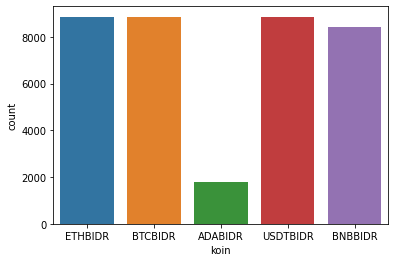

In [ ]:
import seaborn as sns
sns.countplot(data = df, x = 'koin')

In [ ]:
# export data ke excel
df_sub.to_excel('/content/hasil.xlsx')